In [3]:
#download dataset from kaggle
#https://www.kaggle.com/datasets/adityakadiwal/water-potability/data
import kagglehub

# Import das Bibliotecas
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    log_loss,
    precision_score,
    recall_score,
)
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import train_test_split

import mlflow

path = kagglehub.dataset_download("adityakadiwal/water-potability", force_download=True)
print("Path to dataset files:", path)


100%|██████████| 251k/251k [00:00<00:00, 1.05MB/s]

Extracting files...
Path to dataset files: /home/ufscar/.cache/kagglehub/datasets/adityakadiwal/water-potability/versions/3


In [14]:
# abrindo arquivo
data_df = pd.read_csv(path + '/water_potability.csv')

In [15]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [16]:
#dropa linhas com NA
data_df.dropna(inplace=True)

In [17]:
#correlaçao entre PH e Potability
corr_Ph_Potability = data_df[['ph', 'Potability']].corr()
corr_Ph_Potability


,ph,Potability
ph,1.00000,0.01453
Potability,0.01453,1.00000


In [18]:
# Split dos dados
data_df_train, data_df_test = train_test_split(data_df,
                                               test_size=0.30,
                                               random_state=0,
                                               shuffle=True)

In [19]:
# Normalização dos dados numéricos
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

numeric_features = ['ph',
                    'Hardness',
                    'Solids',
                    'Chloramines',
                    'Sulfate',
                    'Conductivity',
                    'Organic_carbon',
                    'Trihalomethanes',
                    'Turbidity']
categorical_features = ['Potability']
transformer = ColumnTransformer([
    ('numeric', RobustScaler(), numeric_features)
])

X_train = transformer.fit_transform(data_df_train)
features = transformer.get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(transformer.transform(data_df_test), columns=features)

y_train = data_df_train['Potability']
y_test = data_df_test['Potability']

/tmp/ipykernel_27921/3715619321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Potability'] = 1


In [20]:
#Funçoes utilizadas
def get_model_metrics(model_name, threshold, y_prob, y_test):
    # salvando resultado
    y_pred = (y_prob > threshold)*1
    acc_estimate = round(acc(y_test,y_pred), 3)
    log_estimate = round(log_loss(y_test,y_prob), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1_score = round(metrics.f1_score(y_test, y_pred), 3)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = 'all')
    plt.show()


    return pd.DataFrame({
        'Method': [model_name],
        'Acuracia': [acc_estimate],
        "Precisao": [precision],
        "Recall": [recall],
        'F1': [f1_score],
        'Log-loss': [log_estimate]
    })

# Modelo LogisticRegression

In [21]:
models = {}
metricas = pd.DataFrame(columns = [
    'Method',
    'Acuracia',
    'Precisao',
    "Recall",
    'F1',
    'Log-loss'])

logistic_none = linear_model.LogisticRegression(penalty=None, max_iter=1000)
logistic_none.fit(X=X_train, y=y_train)

models['Logistica_sem_penalizacao'] = logistic_none

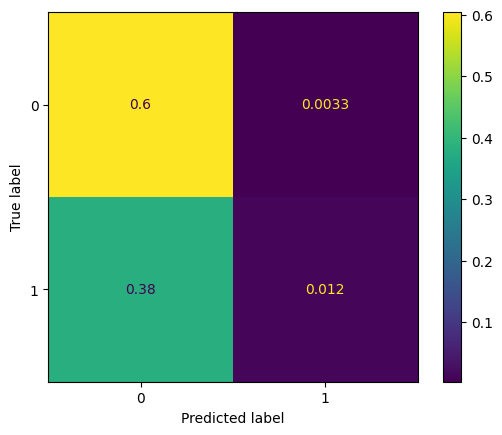

/tmp/ipykernel_27921/1797884712.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metricas = pd.concat([metricas, resultado_modelo])


,Method,Acuracia,Precisao,Recall,F1,Log-loss
0,Logistica_sem_penalizacao,0.616,0.778,0.03,0.057,0.674


In [22]:
#Computa metricas do modelo
resultado_modelo = get_model_metrics(
    model_name='Logistica_sem_penalizacao',
    threshold=.5,
    y_prob=models['Logistica_sem_penalizacao'].predict_proba(X_test)[:,1],
    y_test=y_test)

metricas = pd.concat([metricas, resultado_modelo])
metricas

## Salva no mlflow

In [23]:
# Inicializa o mlflow
mlflow.set_tracking_uri('http://localhost:5001')
mlflow.set_experiment("Potability2")

mlflow.start_run(run_name="Logistica_sem_penalizacao")
parametros = {
    "n_entries": 2011,
    "penalty": None,
}
resultado_modelo = {
    "acuracia" : metricas['Acuracia'],
    "f1": metricas['F1'],
    "log-loss": metricas['F1'],
    "precisao": metricas['Precisao'],
    "recall": metricas['Recall']
}
mlflow.log_params(parametros)
mlflow.log_metrics(resultado_modelo)
mlflow.sklearn.log_model(logistic_none, "linear_no_penalty")
mlflow.end_run()

2025/04/01 17:42:02 INFO mlflow.tracking.fluent: Experiment with name 'Potability2' does not exist. Creating a new experiment.
/home/ufscar/PycharmProjects/mlflow/.venv/lib/python3.12/site-packages/mlflow/tracking/metric_value_conversion_utils.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(x)
2025/04/01 17:42:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistica_sem_penalizacao at: http://localhost:5001/#/experiments/1/runs/02c62695770449389b2860870bbde48c
🧪 View experiment at: http://localhost:5001/#/experiments/1


In [24]:
mlflow.end_run()

## Logistica com penalizacao

In [25]:
#Logistica com L1
logistic_l1 = linear_model.LogisticRegressionCV(
    penalty="l1",
    solver='liblinear',
    scoring='neg_log_loss',
    max_iter=50, cv=10).fit(X=X_train, y=y_train)
models["Logistica_com_l1"] = logistic_l1

/home/ufscar/PycharmProjects/mlflow/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


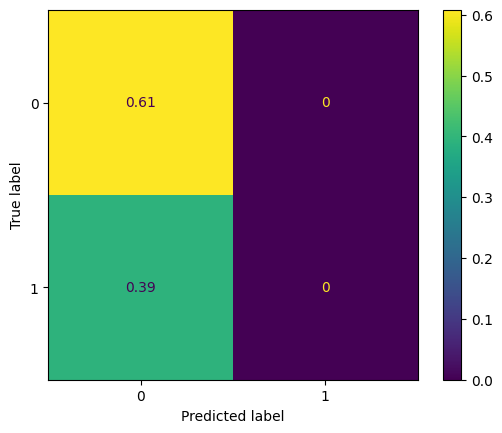

/tmp/ipykernel_27921/1086857272.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metricas_l1 = pd.concat([metricas_l1, resultado_modelo2])


,Method,Acuracia,Precisao,Recall,F1,Log-loss
0,Logistica_com_l1,0.608,0.0,0.0,0.0,0.672


In [27]:
#Computa metricas do modelo
metricas_l1 = pd.DataFrame(columns = ['Method',
                                      'Acuracia',
                                      'Precisao',
                                      "Recall",
                                      'F1',
                                      'Log-loss'])
resultado_modelo2 = get_model_metrics(
    model_name='Logistica_com_l1',
    threshold=.5,
    y_prob=models['Logistica_com_l1'].predict_proba(X_test)[:,1],
    y_test=y_test)

metricas_l1 = pd.concat([metricas_l1, resultado_modelo2])
metricas_l1

In [28]:
# salva no mlflow
mlflow.set_tracking_uri('http://localhost:5001')
mlflow.set_experiment("Potability2")

mlflow.start_run(run_name="Logistica_com_l1")

resultado_l1 = {
    "acuracia" : metricas_l1['Acuracia'],
    "f1": metricas_l1['F1'],
    "log-loss": metricas_l1['F1'],
    "precisao": metricas_l1['Precisao'],
    "recall": metricas_l1['Recall']
}
mlflow.log_params(parametros)
mlflow.log_metrics(resultado_l1)
mlflow.sklearn.log_model(logistic_l1, "linear_with_l1")
mlflow.end_run()

/home/ufscar/PycharmProjects/mlflow/.venv/lib/python3.12/site-packages/mlflow/tracking/metric_value_conversion_utils.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(x)
2025/04/01 17:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistica_com_l1 at: http://localhost:5001/#/experiments/1/runs/c4d01985a24945cabcdd0fcb8392b6d4
🧪 View experiment at: http://localhost:5001/#/experiments/1


In [29]:
resultado_modelo2

,Method,Acuracia,Precisao,Recall,F1,Log-loss
0,Logistica_com_l1,0.608,0.0,0.0,0.0,0.672


In [ ]:
#TODO Registro do modelo no MLFlow